### Example in Computer Vision

We will build a model on the MNIST dataset to recognize hand-written digits.


In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms
%matplotlib inline

print (torch.__version__)
print (torchvision.__version__)

1.5.1
0.6.1


In [4]:
# get train and test data, will automatically download
transform = transforms.ToTensor()

train_data = torchvision.datasets.MNIST(root='mnist', train=True, 
                    transform=transform, download=True)
test_data = torchvision.datasets.MNIST(root='mnist', train=False,
                    transform=transform)


In [5]:
# dataset statistics
print (len(train_data))
print (len(test_data))

60000
10000


Images in MNIST show hand-writtern digits, the task is to recognize the digit. Let's first see an example:

Label: 5


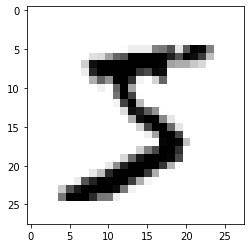

In [6]:
img, lab = train_data[0]
print ("Label:", lab)

img = img.reshape(28, 28)
import matplotlib.pyplot as plt
plt.imshow(img, cmap='binary')

As we can see in the example above, the image shows '5', and the corresponding label is 5. 

Next, we write a model class to perform the task. Note that I'm using a very naive model structure, you can feel free to change the model structure and see if you can get better performance!

In [7]:
# define our model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # conv2d parameters: in_channels, out_channels, kernel_size, stride
        # input shape: (bsz, 1, 28, 28)
        self.conv = nn.Conv2d(in_channels=1, 
                              out_channels=32, 
                              kernel_size=3, 
                              stride=1, 
                              padding=1) 
        # output shape: (bsz, 32, 28, 28)
        self.dropout1 = nn.Dropout2d(0.2)
        self.dropout2 = nn.Dropout(0.4)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # output shape: (bsz, 32, 14, 14)
        self.fc1 = nn.Linear(6272, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.conv(x) #(bsz, 1, 28, 28) -> (bsz, 32, 28, 28)
        x = self.relu(x) 
        x = self.pool(x) #-> (bsz, 32, 14, 14)
        x = self.dropout1(x)
        x = torch.flatten(x, 1) #->(bsz, 6272)
        x = self.fc1(x) #->(bsz, 128)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x) #->(bsz, 10) ##raw logits
        return x   
        

In [8]:
# define our training function
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    loss_fn = nn.CrossEntropyLoss()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 200 == 0:
            print ('Train Epoch: {}, Batch Index: {}, Loss: {}'.format(
                epoch, batch_idx, loss.item()))
        

In [9]:
# define out testing function
def test(model, device, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1,) #(bsz,)
            correct += pred.eq(target).sum().item()
    print (" Test Accuracy: {}%".format(
            correct/len(test_loader.dataset)*100))


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BSZ = 64
LR = 1e-3
EPOCH = 1

# we need to use DataLoader to pass data to the model
# it will yield batches of data
train_loader = torch.utils.data.DataLoader(train_data, 
                                          batch_size=BSZ,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data,
                                         batch_size=BSZ)
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)
for epoch in range(1, EPOCH+1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

    ## uncomment this line to save the trained model 
#     torch.save(model.state_dict(), "mnist_cnn.pt")

Train Epoch: 1, Batch Index: 0, Loss: 2.305495023727417
Train Epoch: 1, Batch Index: 200, Loss: 0.3825370669364929
Train Epoch: 1, Batch Index: 400, Loss: 0.3247998356819153
Train Epoch: 1, Batch Index: 600, Loss: 0.24327732622623444
Train Epoch: 1, Batch Index: 800, Loss: 0.09452737867832184
 Test Accuracy: 97.49%


To save time, I trained for only one epoch.

You can try training for more epochs, designing better model structures or use other tricks to further improve the performance.

In [10]:
# save the model so you can load it later
SAVE_PATH = "mnist_cnn.ckpt"
torch.save(model.state_dict(), SAVE_PATH)

## load the model 
model = Net()
model.load_state_dict(torch.load(SAVE_PATH))


<All keys matched successfully>

In [11]:
# write a predict function to do prediction
def predict(model, img):
    model.eval()
    output = model(torch.reshape(img,(1,1,28,28)))
    pred = output.argmax(dim=1,)
    return pred.item()

Label: 7


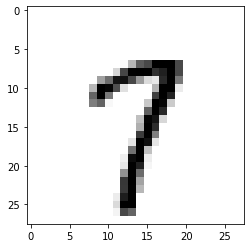

In [13]:
## Pick a random image from Test Set and see what the model predicts
img, lab = test_data[666]
print ("Label:", lab)

img = img.reshape(28, 28)
import matplotlib.pyplot as plt
plt.imshow(img, cmap='binary')

In [14]:
print ("Model prediction:", predict(model, img))

Model prediction: 7


Change the index above to compare results for other test images!

Reference: https://github.com/pytorch/examples/tree/master/mnist